Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
ab_products – подробная информация о продуктах, их название и стоимость


# Выводы: Предварительно можно сделать выводы о положительном влиянии новой системы рекомендаций и необходимости внедрения на всех пользователей. Обязательно обсудить с держателями процесса, обсудить все нюансы полученных данных и их корректность. Если можно взять ещё один срез данных, то взять и подтвердить/опровергнуть ранее полученные результаты.

# Расчёты

In [22]:
# Импортируем необходимые библиотеки.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import ks_2samp


import requests
from urllib.parse import urlencode

In [23]:
# Считываем данныве трёх датафреймов.

ab_products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-repin/ab_products.csv')
ab_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-repin/ab_orders.csv')
ab_users_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-repin/ab_users_data.csv')

# Просмотрим данные датафрэймов для понимания столбцов и значений.

In [14]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [15]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [16]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


# Подготовка датафрейма для будущего изучения.

In [24]:
# Превращаем словарь из значений датафрэйма ab_orders столбца product_ids в список.

ab_orders['product_ids'] = (ab_orders['product_ids']
                            .str.strip('{}')
                            .str.split(', ')
                            .apply(lambda x: [int(i) for i in x]))

ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56.000000,"[74, 6]"
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"


In [27]:
# Изменяем таблицу для удоства считывания id продукта и его цены.

products_index = ab_products.set_index('product_id')
products_index

,name,price
product_id,,
1,сахар,150.0
2,чай зеленый в пакетиках,50.0
3,вода негазированная,80.4
4,леденцы,45.5
5,кофе 3 в 1,15.0
...,...,...
83,вафли,55.0
84,мандарины,90.4
85,варенье,200.3


In [28]:
# Считаем сумму каждого заказа.

ab_orders['order_sum'] = (ab_orders['product_ids']
                          .apply(lambda x:sum([products_index.loc[i]['price'] for i in x])))
ab_orders

,order_id,creation_time,product_ids,order_sum
0,1255,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",408.7
1,1256,2022-08-26 00:02:21.000000,"[56, 76, 39]",250.5
2,1257,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",310.2
3,1258,2022-08-26 00:02:56.000000,"[74, 6]",85.0
4,1259,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]",228.0
...,...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"[84, 8, 24]",241.2
4119,59439,2022-09-08 23:18:05.000000,"[9, 25, 75, 30, 6]",518.5
4120,59464,2022-09-08 23:22:27.000000,"[60, 41, 46]",185.9
4121,59487,2022-09-08 23:29:06.000000,"[9, 62, 77]",501.9


In [29]:
# Производим совмещение двух датафрэймов. Добавляем столбец с количеством продуктов в заказе.

ab_users_data_ab_orders = ab_users_data.merge(ab_orders, on = 'order_id')
ab_users_data_ab_orders['products_quantity'] = ab_users_data_ab_orders.product_ids.apply(lambda x: len(x))
ab_users_data_ab_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids,order_sum,products_quantity
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]",408.7,4
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,"[56, 76, 39]",250.5,3
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]",310.2,4
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",85.0,2
4,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56.000000,"[74, 6]",85.0,2
...,...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,2022-09-08 23:13:03.000000,"[84, 8, 24]",241.2,3
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,2022-09-08 23:18:05.000000,"[9, 25, 75, 30, 6]",518.5,5
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,2022-09-08 23:22:27.000000,"[60, 41, 46]",185.9,3
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,2022-09-08 23:29:06.000000,"[9, 62, 77]",501.9,3


In [30]:
# Переводим столбцы в timedelta формат.

ab_users_data_ab_orders['creation_time'] = pd.to_datetime(ab_users_data_ab_orders['creation_time'])
ab_users_data_ab_orders['time'] = pd.to_datetime(ab_users_data_ab_orders['time'])

In [90]:
# Проверяем статусы заказов, чтбы убрать ненужные.

ab_users_data_ab_orders.action.unique()

array(['create_order'], dtype=object)

In [31]:
#  Убираем из датафрэйма отменённые заказы.

ab_users_data_ab_orders = ab_users_data_ab_orders.query('action == "create_order"')
ab_users_data_ab_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids,order_sum,products_quantity
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]",408.7,4
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]",250.5,3
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]",310.2,4
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]",85.0,2
5,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]",228.0,4
...,...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,2022-09-08 23:13:03,"[84, 8, 24]",241.2,3
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]",518.5,5
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,2022-09-08 23:22:27,"[60, 41, 46]",185.9,3
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,"[9, 62, 77]",501.9,3


In [32]:
#  Проверяем количество пользователей в группах.

ab_users_data_ab_orders.group.value_counts()

1    2514
0    1609
Name: group, dtype: int64

In [33]:
# Проверяем на наличие отсутствующих значений во всех столбцах датафрэйма.

ab_users_data_ab_orders.isna().sum()

user_id              0
order_id             0
action               0
time                 0
date                 0
group                0
creation_time        0
product_ids          0
order_sum            0
products_quantity    0
dtype: int64

In [34]:
# Проверим нужны ли нам две колонки с датой и временем в датафрейме.

(ab_users_data_ab_orders.time == ab_users_data_ab_orders.creation_time).value_counts()

# На основании данных один из столбцов удалим и получим финальный датафрэйм для анализа.

ab_users_data_ab_orders.drop('creation_time', axis=1, inplace=True)

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
# Финальный датафрэйм для анализа.

ab_users_data_ab_orders.head()

,user_id,order_id,action,time,date,group,product_ids,order_sum,products_quantity
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,"[75, 22, 53, 84]",408.7,4
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,"[56, 76, 39]",250.5,3
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,"[76, 34, 41, 38]",310.2,4
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,"[74, 6]",85.0,2
5,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,"[20, 45, 67, 26]",228.0,4


In [36]:
ab_users_data_ab_orders.dtypes

user_id                       int64
order_id                      int64
action                       object
time                 datetime64[ns]
date                         object
group                         int64
product_ids                  object
order_sum                   float64
products_quantity             int64
dtype: object

In [37]:
#  Посчитаем количество пользователей во всём датафрэйме и посмотрим, у всех ли пользователей по 1 заказу.

ab_users_data_ab_orders.user_id.value_counts()

1170    13
1533    13
1641    13
1583    12
1537    12
        ..
1452     1
1381     1
1385     1
1409     1
1174     1
Name: user_id, Length: 1017, dtype: int64

In [38]:
# Сделаем две группы для анализа - контрольную и тестовую.

control = ab_users_data_ab_orders.query('group == 0')
test = ab_users_data_ab_orders.query('group == 1')

In [ ]:
# Проверим, насколько правильно сравнивать группы между собой и сопоставимы ли они по количеству пользователей.

In [122]:
control.user_id.nunique()

515

In [120]:
test.user_id.nunique()

502

In [39]:
control

,user_id,order_id,action,time,date,group,product_ids,order_sum,products_quantity
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,"[75, 22, 53, 84]",408.7,4
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,"[76, 34, 41, 38]",310.2,4
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,"[74, 6]",85.0,2
6,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,"[30, 35, 69, 6]",430.7,4
7,969,1262,create_order,2022-08-26 00:06:25,2022-08-26,0,"[23, 69, 45, 33]",358.6,4
...,...,...,...,...,...,...,...,...,...
4326,1194,59176,create_order,2022-09-08 22:18:26,2022-09-08,0,"[69, 19, 83]",410.3,3
4327,1745,59186,create_order,2022-09-08 22:20:21,2022-09-08,0,"[83, 7, 38, 5]",497.1,4
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,"[60, 41, 46]",185.9,3
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,"[9, 62, 77]",501.9,3


In [40]:
test

,user_id,order_id,action,time,date,group,product_ids,order_sum,products_quantity
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,"[56, 76, 39]",250.5,3
5,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,"[20, 45, 67, 26]",228.0,4
8,970,1263,create_order,2022-08-26 00:08:22,2022-08-26,1,"[22, 23, 5]",180.3,3
9,971,1264,create_order,2022-08-26 00:10:53,2022-08-26,1,"[60, 5, 33, 69]",310.3,4
11,973,1266,create_order,2022-08-26 00:12:00,2022-08-26,1,"[54, 39]",46.0,2
...,...,...,...,...,...,...,...,...,...
4329,1076,59220,create_order,2022-09-08 22:27:41,2022-09-08,1,"[68, 79, 39, 63]",264.2,4
4330,990,59250,create_order,2022-09-08 22:34:34,2022-09-08,1,"[33, 28, 5]",150.3,3
4331,1671,59390,create_order,2022-09-08 23:06:40,2022-09-08,1,"[43, 79, 79, 4, 46]",620.8,5
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,"[84, 8, 24]",241.2,3


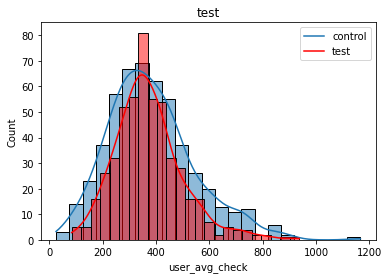

In [41]:
# Проверим средний чек в контрольной и тестовой группах.

sns.histplot(control.groupby('user_id')['order_sum'].mean(), kde=True)
plt.title('control')
sns.histplot(test.groupby('user_id')['order_sum'].mean(), color = 'r', kde=True)
plt.title('test')
plt.xlabel('user_avg_check')
plt.legend(["control", "test"])


# На основании построенного histplot видно, что средний чек "упал" в тестовой группе.

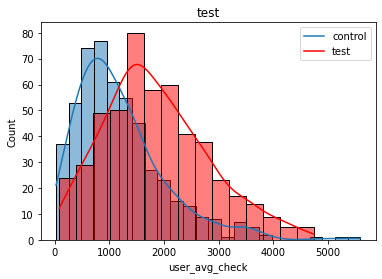

In [42]:
# Проверим потраченные деньги каждого пользователя за время теста.

sns.histplot(control.groupby('user_id')['order_sum'].sum(), kde=True)
plt.title('control')
sns.histplot(test.groupby('user_id')['order_sum'].sum(), color = 'r', kde=True)
plt.title('test')
plt.xlabel('user_avg_check')
plt.legend(["control", "test"])
 
# На основании построенного histplot видно, что суммарные покупки в тестовой группе выше, чем в котрольной.
# То есть пользователи тестовой группы тратят больше денег, чем из контрольной.

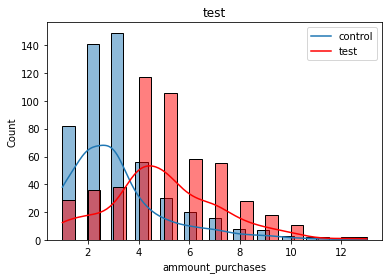

In [43]:
# Проверим количество покупок в контрольной и тестовой группах.

sns.histplot(control.groupby('user_id')['order_id'].count(), kde=True)
plt.title('control')
sns.histplot(test.groupby('user_id')['order_id'].count(), color = 'r', kde=True)
plt.title('test')
plt.xlabel('ammount_purchases')
plt.legend(["control", "test"])


# На основании построенного histplot видно, что количество покупок в тестовой группе выше, чем в контрольной.

## На основании построенных histplot'ов видно, что распределение не является нормальным и имеет большие хвосты.

# Проверка метрик на выявление статистически значимых различий.

# Проверим наши заключения по поводу значимых различий среднего чека через t-test Стьюдента, потому как переменные являются 
бесконечными, мы ищем отличия средних в двух группах.

In [47]:
scs.ttest_ind(control.groupby('user_id')['order_sum'].mean(),
              test.groupby('user_id')['order_sum'].mean())

Ttest_indResult(statistic=1.1434040168228712, pvalue=0.25314048853144)

In [45]:
# Проверим наши заключения по поводу значимых различий среднего чека через U-критерий Манна-Уитни, потому как переменные являются
# бесконечными мы ищем отличия средних в двух группах.

scs.mannwhitneyu(control.groupby('user_id')['order_sum'].mean(),
              test.groupby('user_id')['order_sum'].mean())

MannwhitneyuResult(statistic=131302.0, pvalue=0.6636667887942074)

## На основании данных тестов мы НЕ МОЖЕМ отменить нулевую гипотезу о равенстве групп по среднему чеку. Различия незначимы. P-value больше 0,05.

# Проверим значимость различий по выручке на 1 пользователя (ARPU) в двух группах через t-test Стьюдента, U-критерий Манна-Уитни и критерий Колмогорова-Смирнова.

In [54]:
# T-test Стьюдента.

scs.ttest_ind(control.groupby('user_id')['order_sum'].sum(),
              test.groupby('user_id')['order_sum'].sum())

Ttest_indResult(statistic=-11.780457898190377, pvalue=4.0707633720261776e-30)

In [49]:
# U-критерий Манна-Уитни.

scs.mannwhitneyu(control.groupby('user_id')['order_sum'].sum(),
              test.groupby('user_id')['order_sum'].sum())

MannwhitneyuResult(statistic=73198.0, pvalue=4.984613365045048e-33)

In [50]:
# критерий Колмогорова-Смирнова.

statistic, p_value = ks_2samp(control.groupby('user_id')['order_sum'].sum(),
              test.groupby('user_id')['order_sum'].sum())
print(statistic),
print(p_value)

0.358159594631184
1.1258064751748352e-29


## На основании данных тестов мы МОЖЕМ отменить нулевую гипотезу о равенстве групп по выручке на 1 пользователя (ARPU). Различия значимы. P-value меньше 0,05.

# Проверим значимость различий по среднему количеству заказов на 1 пользователя (AOPU) в двух группах через t-test Стьюдента, U-критерий Манна-Уитни.

In [52]:
# T-test Стьюдента.

scs.ttest_ind(control.groupby('user_id')['order_id'].count(),
              test.groupby('user_id')['order_id'].count())

Ttest_indResult(statistic=-14.51086812343365, pvalue=1.6974865514796019e-43)

In [53]:
# U-критерий Манна-Уитни.

scs.mannwhitneyu(control.groupby('user_id')['order_sum'].sum(),
              test.groupby('user_id')['order_sum'].sum())

MannwhitneyuResult(statistic=73198.0, pvalue=4.984613365045048e-33)

## На основании данных тестов мы МОЖЕМ отменить нулевую гипотезу о равенстве групп по количеству заказов на 1 пользователя (AOPU). Различия значимы. P-value меньше 0,05.